# Konwolucyjna sieć neuronowa (ang. Convolutional neural network) o prostej architekturze w analizie czerniaka

## Tworzymy model

In [1]:
import os
import datetime

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-np9i4p76 because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Ładujemy dane do trenowania i walidacji.

In [2]:
datagen = ImageDataGenerator(rescale=1. / 255, 
                             validation_split=0.2,
                             rotation_range=180,
                             horizontal_flip=True,
                             vertical_flip=True,
                             brightness_range=(0.2,1.5))
training_set = datagen.flow_from_directory('/big-data',
                                           target_size=(128, 128),
                                           batch_size=32,
                                           class_mode='categorical',
                                           subset='training')
validation_set = datagen.flow_from_directory('/big-data',
                                           target_size=(128, 128),
                                           batch_size=32,
                                           class_mode='categorical',
                                           subset='validation')

Found 43922 images belonging to 9 classes.
Found 10975 images belonging to 9 classes.


Zapisujemy ilość diagnoz do zmiennej.

In [3]:
DIAGNOSIS_NUMBER = len(training_set.class_indices)

Budujemy model - sieć konwolucyjną z 3 warstwami konwolucyjnymi (ang. convolutional layer) i 2 warstwami gęstymi (ang. dense layer).

In [4]:
model = Sequential([
    # pierwsza warstwa konwolucyjna
    Conv2D(filters=64, 
           kernel_size=3, 
           activation='relu', 
           input_shape=(128, 128, 3)),
    MaxPool2D(pool_size=2, strides=2),

    # druga warstwa konwolucyjna
    Conv2D(filters=64, kernel_size=3, activation='relu'),
    MaxPool2D(pool_size=2, strides=2),

    # trzecia warstwa konwolucyjna
    Conv2D(filters=64, kernel_size=3, activation='relu'),
    MaxPool2D(pool_size=2, strides=2),
    
    
    BatchNormalization(),
    
    # trasformacja macierzy do tablicy (2D -> 1D)
    Flatten(),
    
    # 2 warstwy gęste
    Dense(units=128, activation='relu'),
    Dropout(0.2),
    
    Dense(units=128, activation='relu'),
    Dropout(0.2),

    # warstwa wyjściowa
    Dense(units=DIAGNOSIS_NUMBER, activation='softmax')
])

In [5]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Dodajemy funkcjonalność zbierania danych o wydajności modelu do Tensorboard.

In [6]:
log_dir = '../logs/fit/' + datetime.datetime.now().strftime('cnn')
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

Dodajemy funkcjonalność zapisywania modelu w trakcie jego trenowania. Zwóćmy uwagę, że zapisywany jest tylko jeden model i lepszy nadpisuje gorszy.

In [7]:
checkpoint_path = 'checkpoints/cnn.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto')

Dodajemy funkcjonalność zatrzymania trenowania modelu, jeśli nie będzie poprawy w ciągu 10 epoch.

In [8]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.01, patience=10, restore_best_weights=True)

Trenujemy model.

In [9]:
model.fit(training_set, validation_data=validation_set, epochs=200, callbacks=[tensorboard_callback,
                                                                               checkpoint_callback,
                                                                               early_stop_callback])

Epoch 1/200
1373/1373 [==============================] - 4690s 3s/step - loss: 1.0524 - accuracy: 0.6364 - val_loss: 0.9357 - val_accuracy: 0.6897

Epoch 00001: val_loss improved from inf to 0.93570, saving model to checkpoints/cnn.ckpt
INFO:tensorflow:Assets written to: checkpoints/cnn.ckpt/assets
Epoch 2/200
1373/1373 [==============================] - 4684s 3s/step - loss: 0.9034 - accuracy: 0.6916 - val_loss: 0.8821 - val_accuracy: 0.7115

Epoch 00002: val_loss improved from 0.93570 to 0.88206, saving model to checkpoints/cnn.ckpt
INFO:tensorflow:Assets written to: checkpoints/cnn.ckpt/assets
Epoch 3/200
1373/1373 [==============================] - 4691s 3s/step - loss: 0.8589 - accuracy: 0.7059 - val_loss: 0.8332 - val_accuracy: 0.7156

Epoch 00003: val_loss improved from 0.88206 to 0.83320, saving model to checkpoints/cnn.ckpt
INFO:tensorflow:Assets written to: checkpoints/cnn.ckpt/assets
Epoch 4/200
1373/1373 [==============================] - 4693s 3s/step - loss: 0.8377 - accu

## Szacujemy dokładność modelu

Ładujemy dane do testowania.

In [10]:
datagen = ImageDataGenerator(rescale=1. / 255)
testing_set = datagen.flow_from_directory('/big-data-test',
                                           target_size=(128, 128),
                                           batch_size=32,
                                           class_mode='categorical')

Found 2889 images belonging to 9 classes.


Pobieramy diagnozy z danych testowych.

In [11]:
true_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

Prognozujemy diagnozy dla każdego obrazu.

In [12]:
predicted_labels = model.predict(testing_set)

Obliczamy punkty wykresu ROC (Receiver operating characteristic) i metrykę AUC (Area under the curve).

In [13]:
fpr = dict()
tpr = dict()
auc_metric = dict()

diagnosis_index_dict = {v: k for k, v in training_set.class_indices.items()}

for i in range(DIAGNOSIS_NUMBER):
    diagnosis = diagnosis_index_dict[i]
    fpr[diagnosis], tpr[diagnosis], _ = roc_curve(true_labels[:, i], predicted_labels[:, i])
    auc_metric[diagnosis] = auc(fpr[diagnosis], tpr[diagnosis])

Rysujemy wykres ROC (Receiver operating characteristic).

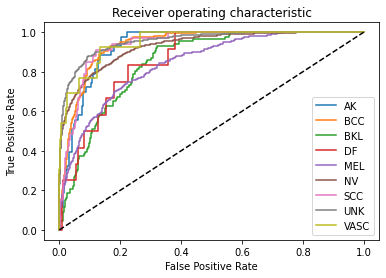

In [14]:
for diagnosis in training_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Metryki AUC do każdej diagnozy.

In [15]:
auc_metric

{'AK': 0.932496036869372,
 'BCC': 0.9381606559505009,
 'BKL': 0.8495216918749845,
 'DF': 0.8623276561232766,
 'MEL': 0.843345830071822,
 'NV': 0.9292567916861934,
 'SCC': 0.9380252100840336,
 'UNK': 0.9561648446644277,
 'VASC': 0.9503584037659142}